<font color="red">Note</font>: the Taxi-v2 environment has been updated to Taxi-v3

# OpenAI: Taxi-v3

* Drop the passenger from starting location(R/G/B/Y) to ending location(either of R/G/B/Y), in minimum time, or in other words, taking the shortest possible route between the locations. 
* A penalty is levied if customer is dropped off at any location other than the destination.
* Walls separate the *lanes* of the environment, the agent cannot go through the walls

## Rules for scoring points
* <font color="green">**+20 points**</font> for successful drop-off
* <font color="red">-1 point</font> for each time-steop(push our agent to be faster
* <font color="red">**-10 points**</font> if illegal pickup/dropoff

In [1]:
from IPython.display import HTML
# original watch link = "https://www.youtube.com/watch?v=QnBq13iILmI"
# here i have embed a video into an ipython frame, which shows the gameplay of taxi-v3
HTML('<iframe src="https://www.youtube.com/embed/QnBq13iILmI?showinfo=0" height="500" width="560" ></iframe>')

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [2]:
import numpy as np
import gym

List all available environments as EnvSpec objects(specifications regarding an instance of an environment, visit [here](https://github.com/openai/gym/blob/master/gym/envs/registration.py) to know more) \
Please visit [here](https://gym.openai.com/envs/#classic_control) to find all available environments. The Taxi-v3 environment comes under *Toy Text*.

In [3]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

# Create the taxi-v3 environment using OpenAI-gym

In [4]:
env = gym.make("Taxi-v3")
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## Create the Q-table

<font size="3">initialise the Q$_{n\times m}$ table, where n = number of possible states = **observation space** and m = number of actions possible = **action space**</font>

In [5]:
actions, observations = env.action_space, env.observation_space
print(type(actions), type(observations))
print("\n","actions is a ",actions,"object, and observations is a",observations,"object")

dash_arr = ['-' for i in range(30)]
s = ''.join(dash_arr)+'dir(Discrete) START'+''.join(dash_arr)
e = ''.join(dash_arr)+'dir(Discrete) END'+''.join(dash_arr)
print("\n"+s+"\n", dir(actions), "\n"+e+"\n")
print(actions.__doc__)

<class 'gym.spaces.discrete.Discrete'> <class 'gym.spaces.discrete.Discrete'>

 actions is a  Discrete(6) object, and observations is a Discrete(500) object

------------------------------dir(Discrete) START------------------------------
 ['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'contains', 'dtype', 'from_jsonable', 'n', 'np_random', 'sample', 'seed', 'shape', 'to_jsonable'] 
------------------------------dir(Discrete) END------------------------------

A discrete space in :math:`\{ 0, 1, \\dots, n-1 \}`. 

    Example::

        >>> Discrete(2)

    


So, we can conclude that a Discrete(n) object is actually a set of integers from 0 to n-1

In [6]:
n, m = observations.n, actions.n
q_table = np.zeros((n,m))
print(q_table.shape)

(500, 6)


## Specify hyperparameters

In [7]:
class Hyperparameters():
    def __init__(self, total_episodes, total_test_episodes, max_steps
                , learning_rate, gamma, epsilon, max_epsilon, min_epsilon, decay_rate):
        self.total_episodes = total_episodes
        self.total_test_episodes = total_test_episodes
        self.max_steps = max_steps
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        
    def __repr__(self):
        return f"hyper(total episodes='{self.total_episodes}', \
total test episodes = '{self.total_test_episodes}', max steps per episode = '{self.max_steps}'\
,learning rate(alpha) = '{self.learning_rate}', gamma or discount rate = '{self.gamma}',\
epsilon or exploration rate = '{self.epsilon}', max-value-of-epsilon = '{self.max_epsilon}', \
min-value-of-epsilon = '{self.min_epsilon}', decay rate for exploration-decay = '{self.decay_rate}')"

In [8]:
# hyperTut stands for hyperparameters used in the tutorial
hyperTut = Hyperparameters(50000, 100, 99, 0.7, 0.618, 1.0, 1.0, 0.01, 0.01)
print(hyperTut)

hyper(total episodes='50000', total test episodes = '100', max steps per episode = '99',learning rate(alpha) = '0.7', gamma or discount rate = '0.618',epsilon or exploration rate = '1.0', max-value-of-epsilon = '1.0', min-value-of-epsilon = '0.01', decay rate for exploration-decay = '0.01')


## Q-learning algorithm

<img src="q_algo_proc2.png" />

In [9]:
done_counter = 0
for episode in range(hyperTut.total_episodes):
    # reset the game environment for each new episode
    state = env.reset()
    step, done = 0, False
    for step in range(hyperTut.max_steps):
        # exploration-exploitation tradeoff
        '''a random number is initialised and compared with the 
        exploration-exploitation rate alpha, if alpha is less 
        than it, it means that agent has learnt sufficient info from this episode
        hence stop exploration and start exploitation '''
        tradeoff = np.random.uniform(0, 1)
        if tradeoff > hyperTut.epsilon:
            # exploitation
            # for the current state, choose the action that gives max Q-value
            action = np.argmax(q_table[state, :])
        else:
            # randomly choose an action from action-space without replacement
            action = actions.sample()
        # take the action, and observe the new-state, reward
        new_state, reward, done, info = env.step(action)
        
        # using the Bellman equation, update the Q-table
        q_table[state, action] = q_table[state, action] + hyperTut.learning_rate * (reward + hyperTut.gamma * 
                                    np.max(q_table[new_state, :]) - q_table[state, action])        
        state = new_state
        if done:
            done_counter += 1
            # If done, finish the episode
            break
    # reduce epsilon for each episode
    hyperTut.epsilon = hyperTut.min_epsilon + (hyperTut.max_epsilon \
- hyperTut.min_epsilon)*np.exp(-hyperTut.decay_rate*episode)
print("Number of times the episode was done is", str(done_counter))

Number of times the episode was done is 49842


# Testing
Test the agent(Q-table) for a few episodes, and print the score after testing

In [10]:
env.reset()
rewards = []
for episode in range(hyperTut.total_test_episodes):
    progress = round(((episode+1)/hyperTut.total_test_episodes)*100, 3)
    state = env.reset()
    step, done, total_rewards = 0, False, 0
#     print(''.join(['*'*15]) + 'EPISODE '+str(episode+1)+' START'+''.join(['*'*15]))
    for step in range(hyperTut.max_steps):
        # UNCOMMENT IT IF YOU WANT TO SEE OUR AGENT PLAYING
        env.render()
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(q_table[state,:])
        
        new_state, reward, done, info = env.step(action)
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            #print ("Score", total_rewards)
            break
        state = new_state
    print(str(progress)+"% completed \n")
#     print("\n", str(rewards[-1]), "\n")
#     print(''.join(['*'*15]) + 'EPISODE '+str(episode+1)+' END'+''.join(['*'*15]))
env.close()
print ("Score over time: " +  str(sum(rewards)/hyperTut.total_test_episodes))    

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y|

  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
48.0% completed 

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| :

  (Pickup)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
94.0% completed 

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : :

In [11]:
env = gym.wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
frames = []
for _ in range(10):
    action = actions.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 27 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/laferrari/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


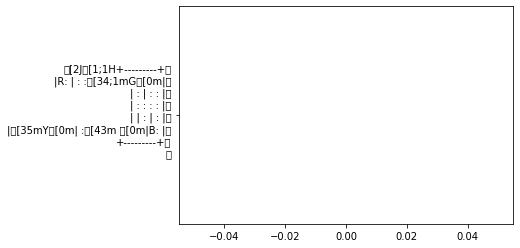

In [13]:
import json
import matplotlib.pyplot as plt
with open("./gym-results/openaigym.video.0.9132.video000000.json") as fp:
    data = json.load(fp)
    for i in range(1):
        plt.plot(data['stdout'][i][1])